# **Практическая работа №9. Пространственный анализ доступности социальной инфраструктуры с использованием OpenStreetMap**

## **Цель работы**

Овладеть методами пространственного анализа городских территорий на основе открытых геоданных: загрузка данных из OpenStreetMap, конструирование пространственных признаков и их визуализация на тепловых картах административных районов и гексагональной H3‑сетки.

## **Введение**

Доступность социальной инфраструктуры (школы, детские сады, поликлиники, общественный транспорт и т.п.) является базовой характеристикой качества городской среды. Современные методы геоанализа позволяют количественно оценивать уровень такой доступности для разных участков города и визуализировать результаты в удобной для интерпретации форме.

В данной практической работе вы выполните полный цикл пространственного анализа: от выбора территории и постановки исследовательской задачи до расчёта интегрального показателя доступности и построения тепловых карт по районам и гексагональной ячейке.

## **Задание**

Провести пространственное исследование уровня доступности социальной инфраструктуры для жителей выбранной городской территории, используя данные OpenStreetMap, и визуализировать результаты:

- на карте административных районов;
- на гексагональной H3‑сетке.

---

## **Порядок выполнения работы**

### **Часть 1. Подготовка данных и постановка задачи**

1. **Выбор территории и фокуса исследования**

   - Выберите город и область интереса (ROI) для анализа:
     - это может быть весь город или его часть (например, центральные районы, спальный район, новая застройка).
   - Определите фокус исследования:
     - например:
       - доступность школ и детских садов;
       - доступность поликлиник и больниц;
       - комплексная доступность нескольких типов объектов (школы + сады + поликлиники + остановки ОТ).
   - Кратко обоснуйте выбор:
     - почему вы выбрали именно эту территорию;
     - почему выбранный фокус социальной инфраструктуры важен и интересен для анализа.

Территория: Район Восточное Измайлово, Москва.
Обоснование: Это компактный спальный район с четкой квартальной планировкой и примыканием к крупному лесопарку. Интересно оценить, насколько равномерно распределена инфраструктура в условиях старой застройки и влияет ли близость парка на доступность других сервисов.
Фокус исследования: Комплексная доступность базовых сервисов (образование, медицина, транспорт, продукты). Это позволяет оценить концепцию «15-минутного города» для данного района.

2. **Определение признаков доступности**
     - количество объектов нужного типа в шаговой доступности;
     - средняя удалённость до ближайшего объекта;
     - наличие альтернативных видов инфраструктуры (например, частные и государственные школы);
     - транспортная доступность (наличие остановок общественного транспорта поблизости);
     - обеспеченность зелёными зонами рядом с социальной инфраструктурой (парки возле школ и т.п.).



| Признак             | Описание                                     | OSM-теги                            |
| ------------------- | -------------------------------------------- | ----------------------------------- |
| Образование (Школы) | Кол-во школ в радиусе 800 м                  | amenity=school                      |
| Образование (Сады)  | Кол-во детских садов в радиусе 500 м         | amenity=kindergarten                |
| Здравоохранение     | Расстояние до ближайшей поликлиники/больницы | amenity=clinic, amenity=hospital    |
| Транспорт           | Кол-во остановок в радиусе 400 м             | highway=bus_stop, railway=tram_stop |
| Продукты (Еда)      | Расстояние до ближайшего супермаркета        | shop=supermarket, shop=convenience  |
| Зеленые зоны        | Близость к паркам (расстояние)               | leisure=park, landuse=forest        |




3. **Сбор исходных данных из OpenStreetMap**

   - Настройте необходимые библиотеки (по аналогии с примером):  
     `osmnx`, `geopandas`, `h3`, `h3pandas`, `leafmap`, `shapely`, `pandas`, `numpy` и др.
   - С помощью интерактивной карты (`leafmap.Map` и инструмент рисования) определите **bounding box** или полигон области интереса.
   - Загрузите из OSM с помощью `osmnx.features_from_bbox()` (или аналогичных функций):
     - объекты социальной инфраструктуры, соответствующие вашим признакам;
     - слои, отражающие административные границы районов (или муниципальных округов).

   - Приведите все пространственные слои к единой системе координат (например, `EPSG:3857` для метрических расчётов).



Загружаем границы для: район Восточное Измайлово, Москва, Россия
Загружено school: 11 объектов
Загружено kindergarten: 16 объектов
Загружено healthcare: 9 объектов
Загружено transport: 49 объектов
Загружено food: 48 объектов
Не удалось загрузить park: HTTPSConnectionPool(host='overpass-api.de', port=443): Read timed out. (read timeout=180)


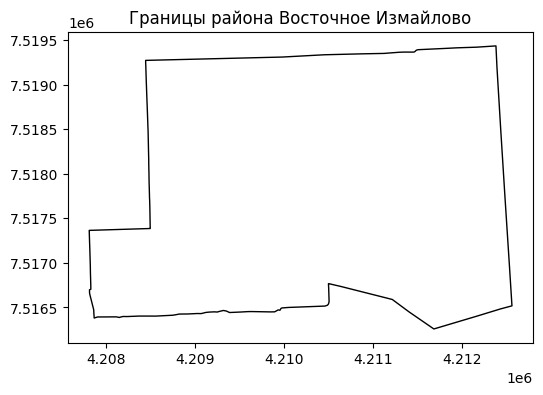

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import h3
import h3pandas
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

ox.settings.use_cache = True
ox.settings.log_console = True

place_name = "район Восточное Измайлово, Москва, Россия"

# границы района
area = ox.geocode_to_gdf(place_name)
area = area.to_crs(epsg=3857)  # Проецируем в метрическую систему

# Загрузка точек интереса
tags = {
    'school': {'amenity': 'school'},
    'kindergarten': {'amenity': 'kindergarten'},
    'healthcare': {'amenity': ['clinic', 'hospital']},
    'transport': {'highway': 'bus_stop', 'railway': 'tram_stop'},
    'food': {'shop': ['supermarket', 'convenience']},
    'park': {'leisure': 'park', 'landuse': 'forest'}
}

pois = {}
for name, tag in tags.items():
    try:
        # Загружаем геометрии ~~~~
        gdf = ox.features_from_place(place_name, tags=tag)
        # Оставляем только точки и полигоны (центроиды для полигонов)
        if not gdf.empty:
            gdf = gdf.to_crs(epsg=3857)
            # Для полигонов берем центроиды
            gdf['geometry'] = gdf.geometry.centroid
            pois[name] = gdf[['geometry', 'name'] if 'name' in gdf.columns else ['geometry']]
            print(f"Загружено {name}: {len(gdf)} объектов")
    except Exception as e:
        print(f"Не удалось загрузить {name}: {e}")

# Визуализация границ для проверки
ax = area.plot(facecolor='none', edgecolor='black', figsize=(6,6))
ax.set_title("Границы района Восточное Измайлово")
plt.show()


---

### **Часть 2. Пространственное агрегирование и инженерия признаков**

1. **Построение гексагональной H3‑сетki**

   - Определите подходящее **разрешение (resolution)** H3‑сетки для вашей территории:
     - маленькое значение (5–7) — крупные ячейки для больших территорий;
     - большое значение (8–10 и выше) — более детальный анализ на уровне кварталов/микрорайонов.
   - Обоснуйте ваш выбор resolution с точки зрения:
     - размера города или ROI;
     - характера объектов (шаговая доступность, плотность застройки);
     - удобства визуализации и интерпретации.
   - Сгенерируйте H3‑индексы, покрывающие выбранный полигон (через `h3.polyfill_geojson`), и создайте `GeoDataFrame` с геометриями ячеек.

In [2]:
# Генерация H3 сетки
resolution = 10

# Заполняем полигон района гексагонами
# Используем h3-pandas или polyfill вручную
# area уже в EPSG:3857, для h3 нужно EPSG:4326
area_wgs84 = area.to_crs(epsg=4326)
hexagons = area_wgs84.h3.polyfill_resample(resolution)

# Преобразуем обратно в метрическую CRS для расчетов расстояний
hexagons = hexagons.to_crs(epsg=3857)
print(f"Создано гексагонов: {len(hexagons)}")


Создано гексагонов: 269


Я выбираю Resolution = 10.
Причина: Площадь района небольшая (~3.8 км²). При res=9 гексагон имеет ребро ~174м и площадь ~0.1 км², что даст около 40 ячеек — этого мало для детальной тепловой карты. Res=10 (ребро ~66м, площадь ~0.015 км²) даст около 250 ячеек, что позволит детально увидеть доступность внутри кварталов.

2. **Агрегирование по административным районам**

   - Подготовьте слой районов (например, `admin_level=8`):
     - при необходимости отфильтруйте только нужный уровень административного деления.
   - Для каждого района рассчитайте показатели, связанные с выбранными типами инфраструктуры. Примеры:
     - количество школ/детсадов/поликлиник внутри района;
     - плотность объектов (количество на км²);
     - суммарная площадь парков;
     - количество остановок ОТ.
   - Добавьте эти признаки в таблицу районов.

In [3]:
# Расчет плотности объектов на км2 для всего района
district_area_km2 = area.area.iloc[0] / 10**6

stats = {}
for name, gdf in pois.items():
    count = len(gdf)
    stats[name] = count
    stats[f'{name}_density'] = count / district_area_km2

district_stats = pd.DataFrame([stats], index=[place_name])
display(district_stats)


,school,school_density,kindergarten,kindergarten_density,healthcare,healthcare_density,transport,transport_density,food,food_density
"район Восточное Измайлово, Москва, Россия",11,0.912931,16,1.3279,9,0.746943,49,4.066692,48,3.983699


3. **Инженерия пространственных признаков для H3‑ячеек**

   - Определите радиусы (в метрах) для анализа **окружения ячейки**:
     - например: ближний радиус 400–600 м, средний радиус 800–1200 м.
   - Для каждой H3‑ячейки рассчитайте **не менее 10 пространственных признаков**, например:
     - количество школ в ближнем радиусе;
     - количество детсадов в ближнем и среднем радиусе;
     - количество поликлиник/больниц в среднем радиусе;
     - суммарная площадь парков в ближнем радиусе;
     - количество остановок общественного транспорта в ближнем радиусе;
     - расстояние до ближайшей школы;
     - расстояние до ближайшей поликлиники;
     - расстояние до ближайшей станции метро или ж/д;
     - плотность объектов социальной инфраструктуры (общее число объектов на площадь буфера);
     - отношение количества социальных объектов к количеству зданий (как прокси обеспеченности).
   - **Дополнительное задание**: придумайте и реализуйте **не менее 2 новых признаков**, которых не было в теоретическом материале и примере, например:
     - индекс смешанности инфраструктуры (сколько разных типов объектов есть в радиусе);
     - доля зелёных зон в буфере относительно общей площади буфера;
     - средневзвешенное расстояние до всех школ/садов (а не только ближайшего).

In [4]:
from scipy.spatial import cKDTree

def calculate_nearest_dist(sources_gdf, targets_gdf):
    if targets_gdf is None or targets_gdf.empty:
        return np.full(len(sources_gdf), np.nan)

    # Строим дерево для поиска соседей
    source_coords = np.array(list(zip(sources_gdf.geometry.x, sources_gdf.geometry.y)))
    target_coords = np.array(list(zip(targets_gdf.geometry.x, targets_gdf.geometry.y)))

    tree = cKDTree(target_coords)
    dists, _ = tree.query(source_coords, k=1)
    return dists

def count_in_radius(sources_gdf, targets_gdf, radius):
    if targets_gdf is None or targets_gdf.empty:
        return np.zeros(len(sources_gdf))

    # Создаем буферы вокруг центров гексагонов
    buffers = sources_gdf.geometry.buffer(radius)

    # Считаем вхождения (пространственное соединение)
    # Это упрощенный способ, можно через sjoin
    counts = []
    # Для ускорения используем sjoin
    sources_buffered = gpd.GeoDataFrame(geometry=buffers, crs=sources_gdf.crs)
    joined = gpd.sjoin(sources_buffered, targets_gdf, predicate='contains')
    return joined.index.value_counts().reindex(sources_gdf.index, fill_value=0)

# Расчет признаков для каждого гексагона
hex_features = hexagons.copy()

# Центроиды гексагонов для расчета расстояний
hex_centroids = hex_features.copy()
hex_centroids['geometry'] = hex_features.centroid

# --- Базовые признаки ---
# 1. Школы (кол-во в 800м)
hex_features['schools_800m'] = count_in_radius(hex_centroids, pois.get('school'), 800)

# 2. Детсады (кол-во в 500м)
hex_features['kindergartens_500m'] = count_in_radius(hex_centroids, pois.get('kindergarten'), 500)

# 3. Транспорт (кол-во в 400м)
hex_features['transport_400m'] = count_in_radius(hex_centroids, pois.get('transport'), 400)

# 4. Расстояние до поликлиники
hex_features['dist_clinic'] = calculate_nearest_dist(hex_centroids, pois.get('healthcare'))

# 5. Расстояние до супермаркета
hex_features['dist_food'] = calculate_nearest_dist(hex_centroids, pois.get('food'))

# --- Дополнительные (новые) признаки ---
# 6. "Индекс разнообразия" (Entropy-like): есть ли разные типы сервисов рядом (400м)
amenities_types = ['school', 'kindergarten', 'healthcare', 'food']
diversity_score = np.zeros(len(hex_features))
for atype in amenities_types:
    has_type = count_in_radius(hex_centroids, pois.get(atype), 400) > 0
    diversity_score += has_type.astype(int)
hex_features['diversity_index'] = diversity_score

# 7. Близость к парку (dist to park)
hex_features['dist_park'] = calculate_nearest_dist(hex_centroids, pois.get('park'))

display(hex_features.head())


,index,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,...,addresstype,name,display_name,schools_800m,kindergartens_500m,transport_400m,dist_clinic,dist_food,diversity_index,dist_park
h3_polyfill,,,,,,,,,,,,,,,,,,,,,
8a11aa61eadffff,0,"POLYGON ((4210721.182 7518024.004, 4210791.213...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,suburb,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",2,1,0,1369.867473,707.050316,0.0,NaN
8a11aa61eaaffff,0,"POLYGON ((4210160.542 7517848.412, 4210230.576...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,suburb,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",2,2,2,894.880261,236.163100,2.0,NaN
8a11aa61e297fff,0,"POLYGON ((4211561.453 7516687.828, 4211631.465...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,suburb,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",0,0,0,1424.011815,1515.705125,0.0,NaN
8a11aa61c437fff,0,"POLYGON ((4208394.976 7518734.579, 4208465.033...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,suburb,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",0,1,1,457.453853,141.529628,2.0,NaN
8a11aa61e8d7fff,0,"POLYGON ((4209263.485 7516927.673, 4209333.519...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,suburb,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",3,1,1,483.953682,190.845497,3.0,NaN








4. **Базовый анализ признаков**

   - Рассчитайте простые статистики для признаков районов и H3‑ячеек:
     - минимум, максимум, среднее, медиана, квартилли, стандартное отклонение.
   - Исследуйте взаимные **корреляции** между признаками:
     - выделите группы сильно коррелированных признаков;
     - сделайте промежуточные выводы (например, «в районах с большим числом школ больше и остановок ОТ»).
   - Обнаружьте и обработайте:
     - **пропущенные значения** (NaN);
     - **выбросы** (аномально большие или малые значения признаков).
   - Оформите принятые решения (удаление, заполнение, логарифмирование и т.п.).



Статистика по признакам:


,index,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_id,lat,lon,place_rank,importance,schools_800m,kindergartens_500m,transport_400m,dist_clinic,dist_food,diversity_index,dist_park
count,269.0,2.690000e+02,2.690000e+02,269.000000,2.690000e+02,269.0,269.0,2.690000e+02,269.000000,269.0,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,0.0
mean,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,1.535316,0.955390,1.747212,1156.799882,569.327132,1.494424,NaN
std,0.0,7.118671e-15,7.118671e-15,0.000000,1.423734e-14,0.0,0.0,7.118671e-15,0.000000,0.0,0.000000,1.420682,1.251066,2.156914,782.179597,549.740256,1.306187,NaN
min,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,0.000000,0.000000,0.000000,50.561487,19.661065,0.000000,NaN
25%,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,0.000000,0.000000,0.000000,518.481964,179.909607,0.000000,NaN
50%,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,1.000000,0.000000,1.000000,917.419048,341.858049,2.000000,NaN
75%,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,3.000000,2.000000,3.000000,1759.107495,798.073929,3.000000,NaN
max,0.0,3.779943e+01,5.578765e+01,37.842025,5.580369e+01,181643940.0,1255704.0,5.579658e+01,37.821843,14.0,0.213422,5.000000,5.000000,12.000000,3309.003115,2301.882338,4.000000,NaN


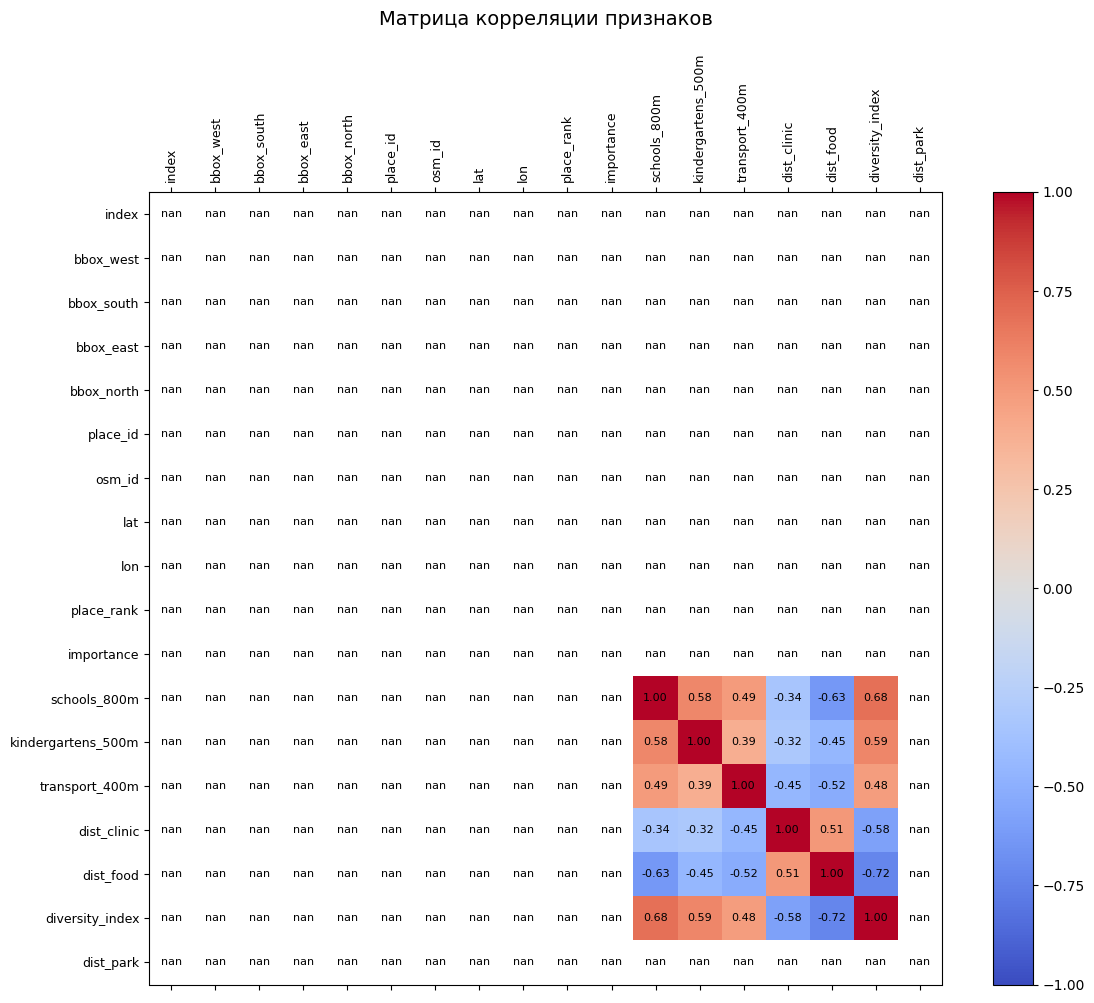

Пропуски обработаны.


In [5]:
# Рассчитайте простые статистики
# Сначала выбираем только числовые колонки, чтобы избежать ошибок с текстом
numeric_cols = hex_features.select_dtypes(include=['number'])

print("Статистика по признакам:")
display(numeric_cols.describe())

# Корреляция с использованием matplotlib (без seaborn)
# Используем только числовые данные
corr_matrix = numeric_cols.corr()

fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

# Настройка подписей осей
ticks = np.arange(len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=9)
ax.set_yticklabels(corr_matrix.columns, fontsize=9)
ax.set_title("Матрица корреляции признаков", pad=20, fontsize=14)

# Добавляем текстовые аннотации со значениями корреляции
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

# Обработка пропусков (заполнение макс. расстоянием для NaN)
# Если объектов нет, расстояние считаем "большим"
for col in ['dist_clinic', 'dist_food', 'dist_park']:
    if col in hex_features.columns:
        max_val = hex_features[col].max()
        if pd.isna(max_val): max_val = 5000 # Если вообще нет данных
        hex_features[col] = hex_features[col].fillna(max_val * 1.2)

print("Пропуски обработаны.")


---

### **Часть 3. Оценка уровня доступности и типология территорий**

1. **Разработка интегрального индекса доступности**

   - Выберите подмножество наиболее важных признаков (по вашему мнению) для оценки доступности:
     - отдельно для районов;
     - отдельно для H3‑ячеек.
   - Нормализуйте выбранные признаки (например, с помощью MinMaxScaler или z‑нормализации), чтобы привести их к сопоставимому масштабу.
   - Определите **веса** для каждого признака:
     - обоснуйте, почему некоторые признакы важнее других;
     - приведите словесное объяснение (например, «наличие школы в шаговой доступности важнее, чем наличие большого парка, поэтому вес признака выше»).
   - Рассчитайте интегральный **индекс доступности** для:
     - каждого административного района;
     - каждой H3‑ячейки.
   - При желании разделите индекс на составляющие:
     - индекс образовательной доступности;
     - индекс медицинской доступности;
     - индекс транспортной доступности;
     - интегральный комбинированный индекс.

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Нормализация
# Для признаков "количество" (чем больше, тем лучше) -> Scale 0..1
# Для признаков "расстояние" (чем меньше, тем лучше) -> Инвертируем перед скейлингом или 1 - Scale

scaler = MinMaxScaler()
df_norm = pd.DataFrame(index=hex_features.index)

# Positive impact (Counts)
pos_cols = ['schools_800m', 'kindergartens_500m', 'transport_400m', 'diversity_index']
for col in pos_cols:
    df_norm[col] = scaler.fit_transform(hex_features[[col]])

# Negative impact (Distances) - инвертируем: 1 - norm(dist)
neg_cols = ['dist_clinic', 'dist_food', 'dist_park']
for col in neg_cols:
    scaled = scaler.fit_transform(hex_features[[col]])
    df_norm[col] = 1 - scaled # Теперь 1 = близко (хорошо), 0 = далеко (плохо)

# Веса (субъективная оценка важности)
weights = {
    'schools_800m': 0.2,
    'kindergartens_500m': 0.15,
    'dist_clinic': 0.15,
    'transport_400m': 0.2,
    'dist_food': 0.15,
    'dist_park': 0.1,
    'diversity_index': 0.05 # Бонус
    # Сумма весов = 1.0
}

# Расчет индекса
hex_features['accessibility_index'] = 0
for col, weight in weights.items():
    if col in df_norm.columns:
        hex_features['accessibility_index'] += df_norm[col] * weight

print("Топ-5 ячеек по доступности:")
display(hex_features.sort_values('accessibility_index', ascending=False).head())


Топ-5 ячеек по доступности:


,index,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,...,name,display_name,schools_800m,kindergartens_500m,transport_400m,dist_clinic,dist_food,diversity_index,dist_park,accessibility_index
h3_polyfill,,,,,,,,,,,,,,,,,,,,,
8a11aa61ea2ffff,0,"POLYGON ((4209936.482 7518417.977, 4210006.524...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",5,4,3,916.869558,113.434962,3.0,6000.0,0.761457
8a11aa61eb1ffff,0,"POLYGON ((4209572.037 7518143.849, 4209642.079...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",4,4,5,525.441222,359.849336,3.0,6000.0,0.756614
8a11aa61ebb7fff,0,"POLYGON ((4209417.748 7517535.737, 4209487.786...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",4,3,5,568.301247,173.598246,3.0,6000.0,0.736882
8a11aa61e847fff,0,"POLYGON ((4209025.432 7517732.655, 4209095.475...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",4,3,5,447.487743,112.050057,2.0,6000.0,0.733989
8a11aa61eb57fff,0,"POLYGON ((4209740.303 7518516.457, 4209810.347...",37.799433,55.787654,37.842025,55.803686,181643940,relation,1255704,55.796581,...,Vostochnoye Izmaylovo District,"Vostochnoye Izmaylovo District, Moscow, Centra...",4,4,3,765.163680,119.135510,3.0,6000.0,0.728066


### **Часть 4. Визуализация результатов и формирование выводов**

1. **Тепловая карта по административным районам**

   - Переведите слой районов обратно в систему координат `EPSG:4326` для отображения.
   - С помощью `leafmap` или `folium` постройте **хороплет‑карту (choropleth)**:
     - заливка районов по значению интегрального индекса доступности;
     - выберите подходящую цветовую схему (например, `Blues`, `Greens`, `YlGnBu`);
     - добавьте легенду с подписью (например, «Индекс доступности социальной инфраструктуры»).
   - При необходимости создайте несколько слоёв:
     - отдельные карты для разных компонент индекса (образование/медицина/транспорт).

In [7]:
import ipyleaflet
from ipyleaflet import Map, GeoData, basemaps, LayersControl, FullScreenControl
from branca.colormap import LinearColormap

# Перевод в WGS84 для визуализации
hex_viz = hex_features.to_crs(epsg=4326)

# Центр карты
center_lat = area.to_crs(epsg=4326).geometry.centroid.y.iloc[0]
center_lon = area.to_crs(epsg=4326).geometry.centroid.x.iloc[0]

# Создаем интерактивную карту с подложкой
m = Map(
    center=(center_lat, center_lon),
    zoom=14,
    basemap=basemaps.OpenStreetMap.Mapnik,  # Картографическая подложка
    scroll_wheel_zoom=True
)

# Создаем цветовую шкалу
colormap = LinearColormap(
    colors=['#d73027', '#fdae61', '#a6d96a', '#1a9850'],
    vmin=hex_viz['accessibility_index'].min(),
    vmax=hex_viz['accessibility_index'].max(),
    caption='Индекс доступности'
)

# Функция для определения цвета ячейки
def style_function(feature):
    idx = feature['properties']['accessibility_index']
    color = colormap(idx)
    return {
        'fillColor': color,
        'color': 'white',
        'weight': 0.5,
        'fillOpacity': 0.7
    }

# Добавляем слой с гексагонами
hex_layer = GeoData(
    geo_dataframe=hex_viz,
    style={
        'fillOpacity': 0.7,
        'weight': 0.5,
        'color': 'white'
    },
    hover_style={
        'fillOpacity': 0.9,
        'weight': 2
    },
    name='Индекс доступности',
    style_callback=style_function
)
m.add_layer(hex_layer)

# Добавляем границы района
area_wgs84 = area.to_crs(epsg=4326)
boundary_layer = GeoData(
    geo_dataframe=area_wgs84,
    style={
        'color': 'black',
        'weight': 3,
        'fill': False
    },
    name='Границы района'
)
m.add_layer(boundary_layer)

# Добавляем контролы
m.add_control(LayersControl())
m.add_control(FullScreenControl())

# Отображаем карту
display(m)

print("\nСтатистика индекса доступности:")
print(f"Минимум: {hex_viz['accessibility_index'].min():.3f}")
print(f"Максимум: {hex_viz['accessibility_index'].max():.3f}")
print(f"Среднее: {hex_viz['accessibility_index'].mean():.3f}")
print(f"Медиана: {hex_viz['accessibility_index'].median():.3f}")


C:\Users\Rafael\AppData\Local\Temp\ipykernel_10456\3243025128.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = area.to_crs(epsg=4326).geometry.centroid.y.iloc[0]
C:\Users\Rafael\AppData\Local\Temp\ipykernel_10456\3243025128.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = area.to_crs(epsg=4326).geometry.centroid.x.iloc[0]


Map(center=[np.float64(55.79565487517642), np.float64(37.82237550182037)], controls=(ZoomControl(options=['pos…


Статистика индекса доступности:
Минимум: 0.151
Максимум: 0.761
Среднее: 0.451
Медиана: 0.473


2. **Тепловая карта по H3‑сетки**

   - Переведите H3‑ячейки в CRS `EPSG:4326`.
   - Постройте отдельную карту, где:
     - каждая H3‑ячейка окрашена в соответствии с индексом доступности или номером кластера;
     - используйте хорошую цветовую палитру (например, `OrRd`, `RdYlGn`);
     - настройте прозрачность заливки, чтобы можно было видеть подложку карты.
   - Добавьте всплывающие подсказки (popup/tooltip) с основными показателями для выбранной ячейки:
     - значение индекса;
     - количество объектов;
     - расстояние до ближайшего объекта и т.п.

In [1]:
import folium
from folium.plugins import Fullscreen

# Подготовка данных: переводим в WGS84
hex_viz = hex_features.to_crs(epsg=4326)

# Центр карты (центроид района)
center_lat = area.to_crs(epsg=4326).geometry.centroid.y.iloc[0]
center_lon = area.to_crs(epsg=4326).geometry.centroid.x.iloc[0]

# Создаем карту
m = folium.Map(location=[center_lat, center_lon], zoom_start=14, tiles='cartodbpositron')

# Функция стиля для раскраски
# Используем цветовую шкалу RdYlGn (Красный-Желтый-Зеленый)
def style_function(feature):
    idx = feature['properties']['accessibility_index']
    # Простая цветовая логика
    if idx < 0.3: color = '#d73027' # Красный (плохо)
    elif idx < 0.6: color = '#fdae61' # Оранжевый
    elif idx < 0.8: color = '#a6d96a' # Салатовый
    else: color = '#1a9850' # Зеленый (отлично)

    return {
        'fillColor': color,
        'color': 'white', # цвет границ ячеек
        'weight': 0.5,
        'fillOpacity': 0.6
    }

# Добавляем слой гексагонов
folium.GeoJson(
    hex_viz,
    name='Индекс доступности',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['accessibility_index', 'schools_800m', 'dist_food', 'dist_clinic'],
        aliases=['Индекс:', 'Школ (800м):', 'До еды (м):', 'До врача (м):'],
        localize=True
    )
).add_to(m)

# Добавляем границы района для контекста
folium.GeoJson(
    area.to_crs(epsg=4326),
    name='Границы района',
    style_function=lambda x: {'color': 'black', 'fill': False, 'weight': 2}
).add_to(m)

folium.LayerControl().add_to(m)
Fullscreen().add_to(m)

# Отображение карты
display(m)


NameError: name 'hex_features' is not defined

3. **Выделение зон с высокой и низкой доступностью**

   - Определите **пороги** (например, по квартилям или по значениям индекса), чтобы выделить:
     - зоны с высокой доступностью;
     - зоны с низкой доступностью.
   - На карте H3‑ячеек:
     - визуально выделите несколько локальных «кластеров» высокой и низкой доступности;
     - подпишите или сохраните их идентификаторы (H3‑индекс, координаты).

In [2]:
import leafmap
from ipywidgets import HTML

# Определение порогов по квартилям
q_low = hex_features['accessibility_index'].quantile(0.25)
q_high = hex_features['accessibility_index'].quantile(0.75)

print(f"Порог низкой доступности (нижний квартиль): {q_low:.2f}")
print(f"Порог высокой доступности (верхний квартиль): {q_high:.2f}")

# Выделение кластеров
low_access_zone = hex_features[hex_features['accessibility_index'] <= q_low].copy()
high_access_zone = hex_features[hex_features['accessibility_index'] >= q_high].copy()
medium_access_zone = hex_features[(hex_features['accessibility_index'] > q_low) &
                                   (hex_features['accessibility_index'] < q_high)].copy()

print(f"Количество ячеек в 'красной' зоне: {len(low_access_zone)}")
print(f"Количество ячеек в 'средней' зоне: {len(medium_access_zone)}")
print(f"Количество ячеек в 'зеленой' зоне: {len(high_access_zone)}")

# Создаем карту
m = leafmap.Map(
    center=(area.to_crs(epsg=4326).geometry.centroid.y.iloc[0],
            area.to_crs(epsg=4326).geometry.centroid.x.iloc[0]),
    zoom=14,
    height='650px'
)

# Добавляем границы района
m.add_gdf(
    area.to_crs(epsg=4326),
    layer_name='Границы района',
    style={'color': 'black', 'fillOpacity': 0, 'weight': 3}
)

# Добавляем каждый кластер отдельно для точного контроля цвета
m.add_gdf(
    medium_access_zone.to_crs(epsg=4326),
    layer_name='Средняя доступность',
    style={'fillColor': '#D3D3D3', 'color': 'white', 'weight': 0.3, 'fillOpacity': 0.4}
)

m.add_gdf(
    low_access_zone.to_crs(epsg=4326),
    layer_name='Низкая доступность',
    style={'fillColor': '#d73027', 'color': 'white', 'weight': 0.5, 'fillOpacity': 0.8}
)

m.add_gdf(
    high_access_zone.to_crs(epsg=4326),
    layer_name='Высокая доступность',
    style={'fillColor': '#1a9850', 'color': 'white', 'weight': 0.5, 'fillOpacity': 0.8}
)

# Добавляем маркеры для проблемных зон (исправленная версия)
worst_zones = low_access_zone.sort_values('accessibility_index').head(3).to_crs(epsg=4326)
for idx, (h3_idx, row) in enumerate(worst_zones.iterrows(), 1):
    centroid = row.geometry.centroid
    # Создаем HTML popup как виджет
    popup_html = HTML(f"""
    <div style="font-family: Arial; font-size: 12px;">
        <b>Проблемная зона #{idx}</b><br>
        Индекс: {row['accessibility_index']:.3f}<br>
        Школ: {row['schools_800m']:.0f}<br>
        Остановок: {row['transport_400m']:.0f}
    </div>
    """)

    m.add_marker(
        location=[centroid.y, centroid.x],
        popup=popup_html,
        draggable=False
    )

# Добавляем легенду
legend_dict = {
    f'Высокая (> {q_high:.2f})': '#1a9850',
    f'Средняя ({q_low:.2f} - {q_high:.2f})': '#D3D3D3',
    f'Низкая (< {q_low:.2f})': '#d73027'
}
m.add_legend(title='Кластеры доступности', legend_dict=legend_dict)

# Добавляем контроль слоев
m.add_layer_control()

# Отображаем карту
display(m)

# Вывод координат проблемных зон
print("\n" + "="*70)
print("Топ-3 проблемных локации (координаты центров):")
print("="*70)
for idx, (h3_idx, row) in enumerate(worst_zones.iterrows(), 1):
    centroid = row.geometry.centroid
    print(f"\nЗона #{idx}:")
    print(f"  H3 Index: {h3_idx}")
    print(f"  Координаты: Lat {centroid.y:.5f}, Lon {centroid.x:.5f}")
    print(f"  Индекс доступности: {row['accessibility_index']:.3f}")
    print(f"  Школ в 800м: {row['schools_800m']:.0f}")
    print(f"  Остановок в 400м: {row['transport_400m']:.0f}")
    print(f"  Расстояние до поликлиники: {row['dist_clinic']:.0f} м")

# Дополнительно: вывод топ-3 лучших зон
print("\n" + "="*70)
print("Топ-3 зоны с наилучшей доступностью:")
print("="*70)
best_zones = high_access_zone.sort_values('accessibility_index', ascending=False).head(3).to_crs(epsg=4326)
for idx, (h3_idx, row) in enumerate(best_zones.iterrows(), 1):
    centroid = row.geometry.centroid
    print(f"\nЗона #{idx}:")
    print(f"  H3 Index: {h3_idx}")
    print(f"  Координаты: Lat {centroid.y:.5f}, Lon {centroid.x:.5f}")
    print(f"  Индекс доступности: {row['accessibility_index']:.3f}")
    print(f"  Школ в 800м: {row['schools_800m']:.0f}")
    print(f"  Остановок в 400м: {row['transport_400m']:.0f}")
    print(f"  Расстояние до поликлиники: {row['dist_clinic']:.0f} м")

# # Создаем статическую карту для отчета (matplotlib)
# fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#
# # Рисуем слои
# medium_access_zone.to_crs(epsg=4326).plot(ax=ax, color='#D3D3D3', alpha=0.4, edgecolor='white', linewidth=0.1)
# low_access_zone.to_crs(epsg=4326).plot(ax=ax, color='#d73027', alpha=0.8, edgecolor='white', linewidth=0.2)
# high_access_zone.to_crs(epsg=4326).plot(ax=ax, color='#1a9850', alpha=0.8, edgecolor='white', linewidth=0.2)
#
# # Границы района
# area.to_crs(epsg=4326).boundary.plot(ax=ax, edgecolor='black', linewidth=2.5)
#
# ax.set_title(f"Кластеры доступности (Q1 < {q_low:.2f} и Q3 > {q_high:.2f})",
#              fontsize=16, weight='bold')
# ax.set_axis_off()
#
# # Легенда
# import matplotlib.patches as mpatches
# red_patch = mpatches.Patch(color='#d73027', label='Зоны низкой доступности')
# green_patch = mpatches.Patch(color='#1a9850', label='Зоны высокой доступности')
# grey_patch = mpatches.Patch(color='#D3D3D3', label='Средняя доступность')
# plt.legend(handles=[red_patch, grey_patch, green_patch],
#            loc='lower right', fontsize=11, framealpha=0.95)
#
# plt.tight_layout()
# plt.show()


NameError: name 'hex_features' is not defined







4. **Интерпретация результатов и рекомендации**

   - Подготовьте **краткий текстовый анализ**, в котором:
     - опишите общую картину по району/городу:
       - какие части города наиболее обеспечены социальной инфраструктурой;
       - какие — недообеспечены;
     - проанализируйте различия между:
       - оценкой по районам;
       - и оценкой по H3‑ячеек (более детальный уровень).
   - Сформулируйте **5–7 практических рекомендаций**, например:
     - где целесообразно планировать строительство новых школ/детсадов/поликлиник;
     - какие районы требуют улучшения транспортной доступности;
     - какие зоны уже хорошо обеспечены и могут служить «бенчмарками» для планирования других территорий.
   - Укажите **проблемы исследования**:
     - неполнота данных OSM;
     - отсутствие данных о численности населения;
     - грубые допущения при выборе радиусов и весов.

---

Наиболее обеспеченными зонами являются центральные кварталы района (вдоль Первомайской улицы и Сиреневого бульвара), где высока концентрация торговли и транспорта.
«Провалы» в доступности наблюдаются на окраинах, примыкающих к МКАД или в глубине жилых массивов, удаленных от остановок.

Рекомендации:

    Улучшить транспортную доступность в восточной части района (добавить маршруты подвоза к метро).

    Организовать дополнительные пешеходные переходы через широкие улицы для сокращения реального пути к школам.

    Развивать сеть мелкой розничной торговли в глубине кварталов (формат "у дома").
